## Need to be running a python  version that works with outlier_utils

[Resource](https://www.alfredo.motta.name/create-isolated-jupyter-ipython-kernels-with-pyenv-and-virtualenv/) for having multiple versions of python + Jupyter. The colab version is 3.6.9 but not an option in pyenv so went with 3.6.8

In [1]:
from platform import python_version

print(python_version())

3.6.8


## Update path_j based on user & install packages

In [2]:
#google drive authorize AND googlesheets4 authorize-- must create a project under google API and then download credentials
#see authentication section in the following article
#https://medium.com/@bretcameron/how-to-use-the-google-drive-api-with-javascript-57a6cc9e5262
#Note: need to open a service account and extract .json credentials in the API console, approve Google Drive API, then share the service account email address with the sheet of interest
path_j='/Users/owner/Desktop/Berkeley_Work/Projects/2017_San_Diego/June 2018_Data_Analysis/access-via-jupiter-notebook-d18b3ab0993b.json' #lauren's


#need  to do the following  in the activated virtual environment
# !pip install gspread
# !pip install oauth2client
# !pip install outliers
# !pip install plotnine
# !pip install scikit-misc
# !pip install outlier_utils
# !pip install pandas
# !pip  install numpy
# !pip install sklearn

In [3]:
import sys
import os
from os import path
from datetime import date
import math
import warnings
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from plotnine import *
from scipy import stats
from scipy.stats import linregress
import gspread
from mizani.formatters import scientific_format
%matplotlib inline


#Set up Google drive access and sheets manipulation

import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name(path_j, scope)


#Authorize credentials and open master sampling table using its URL
gc = gspread.authorize(credentials)
# routine= gc.open_by_url('https://docs.google.com/spreadsheets/d/163xXZnJjh0LdryxrDhuYxgzHB_IY7Jaew3DpYzoNs9Q/edit#gid=1255279898')
# qpcr=gc.open_by_url('https://docs.google.com/spreadsheets/d/1TzZcB2p55BuG5FbXAA44EFoe8BdRapGyDaVR4hx9NXU/edit#gid=1689469809')
import skmisc
import outliers

#sheets
rna_tab = 'sample_inventory'
ww_tab='site_lookup'
facility_lookup='site_lookup'
qpcr_results_tab = 'QuantStudio_raw_data'
qpcr_plates_tab = 'Plate_info'

#urls
samples_url = 'https://docs.google.com/spreadsheets/d/1BROD37xHS0MUmngW8b0-017CMI-MUPs6yUhWZacRBVM/edit#gid=428335760'
qpcr_url = 'https://docs.google.com/spreadsheets/d/1_JRWgH8AJBU8IcxWCmI2Gr7aYlXr0AhKHgVVGW8PXio/edit#gid=1689469809'


# read in custom modules
from read_gsheets import * 
from reprocess_qpcr import *
from calculations import *
from qa_qc import *

In [4]:
# load data for plotting trends over time
# read in data
sample_data = read_sample_data(gc, samples_url, rna_tab, facility_lookup)
qpcr_raw = read_qpcr_data(gc, qpcr_url, qpcr_results_tab, qpcr_plates_tab)
qpcr_processed, std_curve_df, raw_outliers_flagged_df = process_qpcr_raw(qpcr_raw, 'grubbs_only')

# merge with sample data
qpcr_averaged = qpcr_processed.merge(sample_data, how='left', left_on='Sample', right_on='sample_id')
qpcr_averaged = qpcr_averaged[qpcr_averaged.Sample != 'NTC']
qpcr_averaged_xeno = qpcr_averaged
qpcr_averaged = qpcr_averaged[qpcr_averaged.Target != 'Xeno'] #only need in raw_outliers_flagged_df

# calculations
qpcr_averaged['gc_per_L'] = calculate_gc_per_l(qpcr_averaged) # get gc/L
qpcr_averaged = normalize_to_pmmov(qpcr_averaged)
qpcr_averaged = get_GFP_recovery(qpcr_averaged)


#make column for PBS controls assessment
PBS=qpcr_averaged[qpcr_averaged.interceptor=='PBS'][['plate_id','batch','Target','Cq_init_min','Cq_of_lowest_std_quantity','ntc_result']].copy()
PBS.Cq_init_min= pd.to_numeric(PBS.Cq_init_min)
PBS['PBS_result']=np.nan
PBS.loc[np.isnan(PBS.Cq_init_min),"PBS_result"]="negative"
PBS.loc[~np.isnan(PBS.Cq_init_min),"PBS_result"]=PBS.loc[~np.isnan(PBS.Cq_init_min),"Cq_init_min"]

mer=PBS[['plate_id','batch',"Target","PBS_result"]].copy()

qpcr_averaged=qpcr_averaged[qpcr_averaged.interceptor!='PBS'].copy()
qpcr_averaged_merged=qpcr_averaged.merge(mer, how='left')


sample_data["processed"]=0
sample_data.loc[sample_data.date_extract != "","processed"]=1
sample_data["N1_qpcr"]=0
uni=qpcr_averaged[(qpcr_averaged.Target == 'N1')].Sample.unique()
sample_data.loc[sample_data.sample_id.isin(uni) ,"N1_qpcr"]=1
sample_data["paper"]=0
num=['B01','B02','B03','B04','B05','B06','B07','B08','B09','B10','B11','B12','B13','B14','B15']
sample_data.loc[sample_data.batch.isin(num),"paper"]=1
sample_data["sub_id"]=sample_data['sample_id'].str.slice(0, -2)

sample_data_80=sample_data[sample_data.stored_minus_80=='1'].copy()
sample_data=sample_data[sample_data.processed_fresh != '']
sample_data.processed_fresh=sample_data.processed_fresh.astype('int')
sample_data_fresh=sample_data[sample_data.processed_fresh==1].copy()
sample_data_u=sample_data_80[['facility',"interceptor",'date_sampling','date_extract','processed',"N1_qpcr","paper"]].drop_duplicates()
sample_data_fresh_u=sample_data_fresh[['facility',"interceptor",'date_sampling','date_extract','processed',"N1_qpcr","paper"]].drop_duplicates()


sample_data=sample_data[(sample_data.processed_fresh != 1)&(~np.isnan(sample_data.processed_fresh))].copy()


qpcr_averaged_data = qpcr_averaged[qpcr_averaged.inhibition_testing == "N"] # Remove inhibition testing from qPCR averaged
qpcr_unk_long_data = qpcr_averaged_data[qpcr_averaged_data.Task=='Unknown'].copy().reset_index() # filter out standards and copy


/Users/owner/Desktop/Berkeley_Work/data_analysis/calculations.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/owner/Desktop/Berkeley_Work/data_analysis/calculations.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/owner/.pyenv/versions/py3.6.8_outlierutils/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [5]:
#inhibition testing
inhib=1
xeno_inhib_full, xeno_control=xeno_inhibition_test(raw_outliers_flagged_df,x=inhib)

xeno_inhib=xeno_inhib_full.merge(sample_data, left_on='Sample', right_on='sample_id',  how='left').copy()
xeno_inhib=xeno_inhib[(xeno_inhib['batch'].str.contains("B", na=False))].copy()
plates=xeno_inhib.plate_id.unique()

xeno_control=xeno_control[xeno_control.plate_id.isin(plates)].copy()


inhibited=xeno_inhib[xeno_inhib.inhibited== "Yes"].Sample.unique()
not_inhibited=xeno_inhib[xeno_inhib.inhibited== "No"].Sample.unique()

qpcr_averaged_merged["is_inhibited"]='unknown'
qpcr_averaged_merged.loc[qpcr_averaged_merged.Sample.isin(inhibited),"is_inhibited"]="Yes"
qpcr_averaged_merged.loc[qpcr_averaged_merged.Sample.isin(not_inhibited),"is_inhibited"]="No"
qpcr_averaged_merged=qpcr_averaged_merged[(qpcr_averaged_merged['batch'].str.contains("B", na=False))].copy()

In [6]:
xeno_control.plate_id.unique()

array([79, 85, 86, 87, 88, 91, 92, 93, 94, 95])

In [7]:
qpcr_averaged_merged.head()

,plate_id,Sample,Sample_plate,Target,Task,inhibition_testing,template_volume,Q_init_mean,Q_init_std,Q_init_CoV,...,interceptor_general_flow_MGD,gc_per_ul_input,gc_per_L,pmmov_mean,mean_normalized_to_pmmov,log10mean_normalized_to_log10pmmov,log10_mean_normalized_to_pmmov,perc_GFP_recovered,PBS_result,is_inhibited
688,68,C_S68_042120_1,C_S68_042120_1+68,PMMoV,Unknown,N,5.0,392541.97,1.047966,0.038742,...,,74358.660810,3.717933e+08,371793.304049,1.0,1.0,0.0,NaN,38.924,No
689,68,C_S68_042820_1,C_S68_042820_1+68,PMMoV,Unknown,N,5.0,430759.30,1.035485,0.028393,...,,83323.966253,4.166198e+08,416619.831264,1.0,1.0,0.0,NaN,38.924,Yes
690,68,C_S68_051220_1,C_S68_051220_1+68,PMMoV,Unknown,N,5.0,348461.50,1.012244,0.009903,...,,69097.935024,3.454897e+08,345489.675118,1.0,1.0,0.0,NaN,38.924,Yes
691,68,C_S68_051920_1,C_S68_051920_1+68,PMMoV,Unknown,N,5.0,643953.75,1.042602,0.033916,...,,123864.210656,6.193211e+08,619321.053278,1.0,1.0,0.0,NaN,38.924,Yes
692,68,C_S68_052720_1,C_S68_052720_1+68,PMMoV,Unknown,N,5.0,242564.10,1.040208,0.032494,...,,46368.229392,2.318411e+08,231841.146960,1.0,1.0,0.0,NaN,38.924,Yes


/Users/owner/.pyenv/versions/py3.6.8_outlierutils/lib/python3.6/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


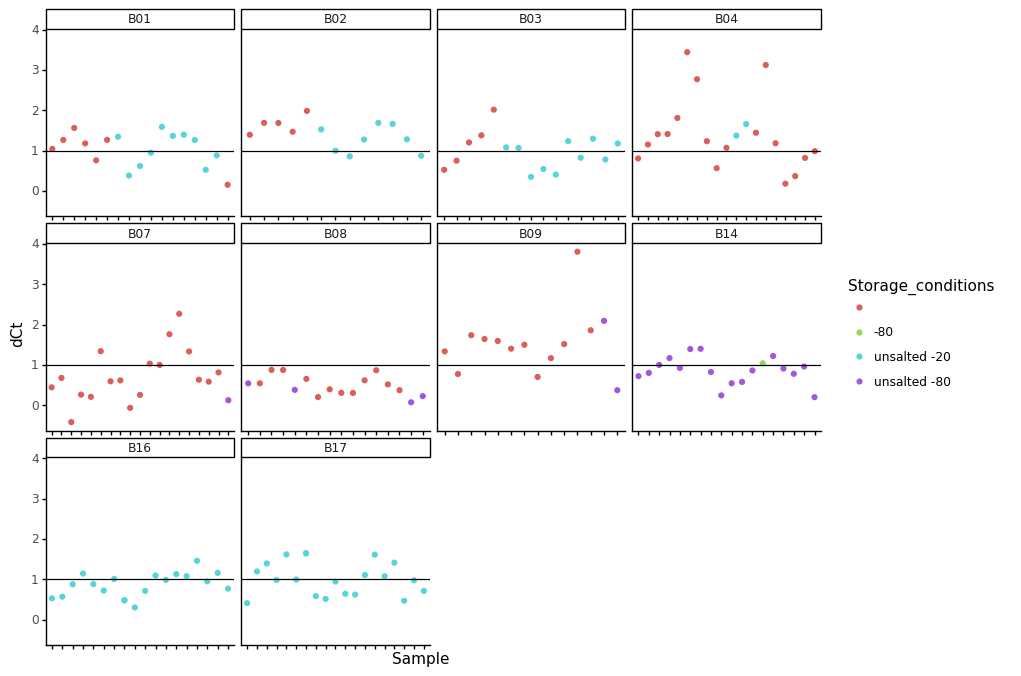

<ggplot: (-9223372036545726783)>

In [8]:
a=xeno_inhib
b=xeno_control
n=len(a.batch.unique())


(ggplot() + 
geom_point(a,aes(x='sample_id', y='dCt',color='Storage_conditions')) +
geom_hline(b, aes(yintercept=inhib))+
facet_wrap('~ batch', scales="free_x")+
ylab('dCt')+
xlab('Sample')+
theme_classic()+ theme(
        axis_text_x=element_blank(),
        figure_size=(10,8)))
 

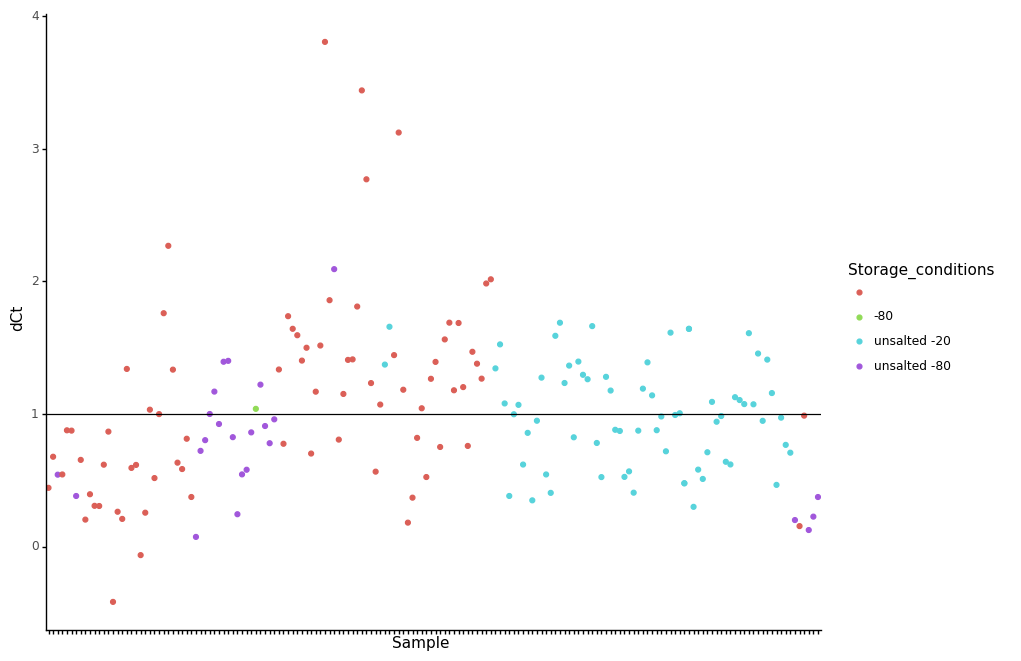

<ggplot: (-9223372036545299049)>

In [9]:
a=xeno_inhib
b=xeno_control
n=len(a.batch.unique())


(ggplot() + 
geom_point(a,aes(x='sample_id', y='dCt',color='Storage_conditions')) +
geom_hline(b, aes(yintercept=inhib))+
# facet_wrap('~ batch', scales="free_x")+
ylab('dCt')+
xlab('Sample')+
theme_classic()+ theme(
        axis_text_x=element_blank(),
        figure_size=(10,8)))

In [10]:
xeno_control.columns

Index(['plate_id', 'Task', 'Quantity_std_crv', 'additional_target',
       'Ct_control_mean'],
      dtype='object')

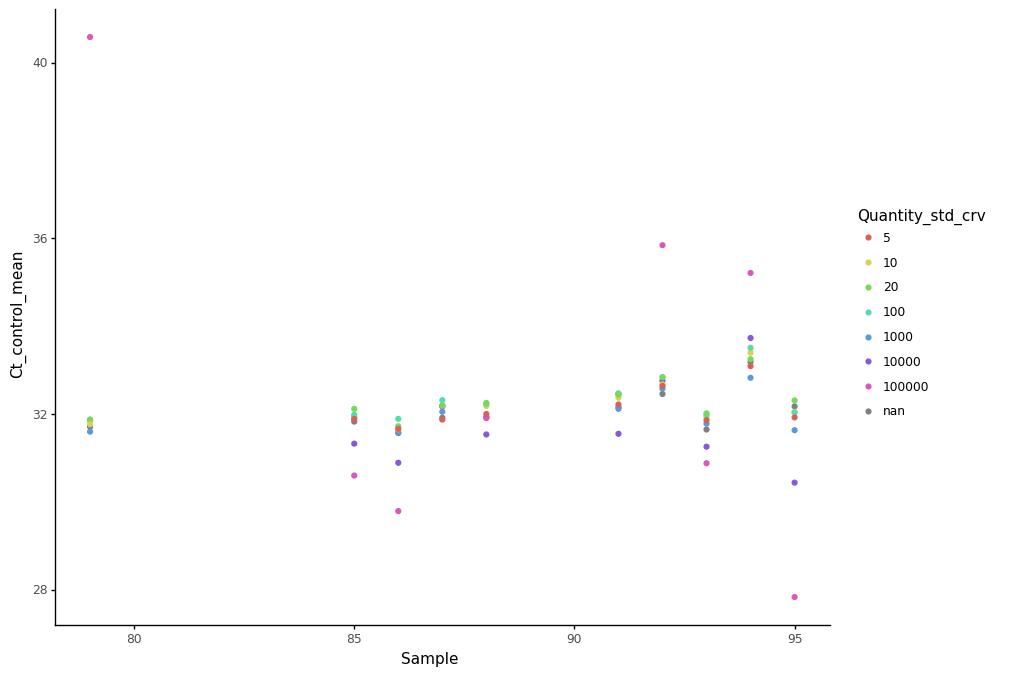

<ggplot: (310120189)>

In [27]:
b=xeno_control
b["Quantity_std_crv"]=b["Quantity_std_crv"].astype("category")

(ggplot() + 
geom_point(b,aes(x='plate_id', y='Ct_control_mean', color='Quantity_std_crv')) +
# geom_hline(b, aes(yintercept=1))+
# facet_wrap('~ batch', scales="free_x")+
# ylab('dCt')+
xlab('Sample')+
theme_classic()+ theme(
        # axis_text_x=element_blank(),
        figure_size=(10,8)))

In [12]:
a=qpcr_averaged_merged[qpcr_averaged_merged.is_inhibited=="Yes"]
len(a.is_inhibited)


92

In [13]:
len(qpcr_averaged_merged.is_inhibited)

185

In [47]:
a=xeno_inhib[xeno_inhib.dCt>=2][["Sample","batch","dCt"]]
samps=a.Sample.unique()
a

,Sample,batch,dCt
33,B_SR_080420_4,B07,2.268274
82,C_N49_081120_4,B09,3.806368
98,C_N49_090120_4,B09,2.092184
104,C_S68_060220_1,B04,3.440421
105,C_S68_060920_1,B04,2.769816
112,C_S68_071420_1,B04,3.122522
148,E_Inf_060720_3,B03,2.015586


In [48]:
qpcr_averaged_merged[qpcr_averaged_merged.Sample.isin(samps)][["Sample","batch","Target","Quantity_mean"]]

,Sample,batch,Target,Quantity_mean
693,C_S68_060220_1,B04,PMMoV,124238.337498
694,C_S68_060920_1,B04,PMMoV,174043.211014
701,C_S68_071420_1,B04,PMMoV,259482.219417
759,E_Inf_060720_3,B03,N1,NaN
795,C_N49_081120_4,B09,N1,73.680851
797,C_N49_090120_4,B09,N1,5.084720
837,C_S68_060220_1,B04,N1,14.597199
838,C_S68_060920_1,B04,N1,7.720823
845,C_S68_071420_1,B04,N1,49.014861
906,B_SR_080420_4,B07,N1,141.531435
